In [9]:
from urllib.request import urlopen
from urllib.parse import urlparse, urldefrag, urljoin
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import json

In [10]:
data = pd.read_excel('rsmp_24.07.2025.xlsx', header=2)

C:\Users\Василий\PycharmProjects\pythonProject5\venv\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [11]:
data.head()

,№ п/п,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности,Регион,Район,Город,...,Дата включения в реестр,Дата исключения из реестра,Телефон,E-mail,WWW,Наличие лицензий,"Производство инновационной, высокотехнологичной продукции",Участие в программах партнерства,Является социальным предприятием,Среднесписочная численность работников за предшествующий календарный год
0,1,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",Юридическое лицо,Малое предприятие,1025004907080,5038038838,41.20 Строительство жилых и нежилых зданий,50 - Московская область,Пушкино г,NaN,...,01.08.2016,NaN,NaN,NaN,NaN,Нет,Нет,Нет,Нет,30.0
1,2,"""ЛАВИНА"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Малое предприятие,1035010952624,5027064258,41.2 Строительство жилых и нежилых зданий,50 - Московская область,Люберцы г,NaN,...,01.08.2016,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,40.0
2,3,"""САНТОЛ"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Малое предприятие,1025204409152,5263038483,41.20 Строительство жилых и нежилых зданий,52 - Нижегородская область,NaN,г Нижний Новгород,...,10.07.2024,NaN,NaN,NaN,NaN,Нет,Нет,Нет,Нет,2.0
3,4,"""ХОЗРАСЧЕТНАЯ СТРОИТЕЛЬНО-ТЕХНОЛОГИЧЕСКАЯ ФИРМ...",Юридическое лицо,Среднее предприятие,1025007270551,5027006369,41.20 Строительство жилых и нежилых зданий,50 - Московская область,Люберцы г,г. Дзержинский,...,01.08.2016,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,128.0
4,5,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""2МЕН ГРУПП ДЕВЕЛОПМЕНТ""",Юридическое лицо,Малое предприятие,1067746424899,7701651356,41.2 Строительство жилых и нежилых зданий,72 - Тюменская область,NaN,г Тюмень,...,10.08.2017,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,14.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11795 entries, 0 to 11794
Data columns (total 22 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   № п/п                                                                     11795 non-null  int64  
 1   Наименование / ФИО                                                        11795 non-null  object 
 2   Тип субъекта                                                              11795 non-null  object 
 3   Категория                                                                 11795 non-null  object 
 4   ОГРН                                                                      11795 non-null  int64  
 5   ИНН                                                                       11795 non-null  int64  
 6   Основной вид деятельности                                     

In [19]:
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

list_df = [pd.DataFrame() for _ in range(5)]


retry = Retry(total=3, backoff_factor=1)
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retry))
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36",
    "Accept": "application/json, text/plain, */*",
    "X-Requested-With": "XMLHttpRequest"
}
for i in data.loc[:, 'ИНН']:
    url = f"https://bo.nalog.gov.ru/advanced-search/organizations/search?query={int(i)}&page=0&size=20"
    #res = session.get(url, headers=headers)

    res = session.get(url, timeout=15, headers=headers).json()
    try:
        org_id = res["content"][0]["id"]
    except IndexError:
        continue
    response = session.get(f"https://bo.nalog.gov.ru/nbo/organizations/{org_id}/bfo/", timeout=15, headers=headers).json()

    for year in range(5):
        try:
            try:
                df_corr = pd.json_normalize(response[year]['typeCorrections'])
                df_info = pd.json_normalize(response[year]['organizationInfo'])
            except NotImplementedError:
                continue
            df_col = [j for j in df_corr.columns if j.startswith('correction.financialResult.current')]
            df = pd.concat([df_info[['fullName', 'inn', 'address']], df_corr[df_col]], axis=1)
            list_df[year] = pd.concat([list_df[year],df])
        except IndexError:
            break
print(list_df[3].head(10))

                                            fullName         inn  \
0  ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "КОРП...  5038038838   
0  Общество с ограниченной ответственностью "ЛАВИНА"  5027064258   
0  Общество с ограниченной ответственностью "Сант...  5263038483   
0  Общество с Ограниченной Ответственностью Хозра...  5027006369   
0                                    АО "2МЕН ГРУПП"  7701651356   
0                         Акционерное общество "777"  1414006922   
0              Акционерное общество "АВАНГАРД-СТРОЙ"  7728738572   
0                  АКЦИОНЕРНОЕ ОБЩЕСТВО "АВТОБЫТДОР"  5018196032   
0               Акционерное Общество "Агротехимпорт"  3327332190   
0                         Акционерное общество "АКС"  7816061297   

                                             address  \
0    141206, Московская обл, ул Чехова, 12, офис 901   
0  140015, Московская обл, Люберцы г, Инициативна...   
0  603037, Нижегородская обл, г.Нижний Новгород, ...   
0  140093, Московская обл, 

In [20]:
with pd.ExcelWriter('fin_pars.xlsx') as writer:
    list_df[0].to_excel(writer, sheet_name='2024')
    list_df[1].to_excel(writer, sheet_name='2023')
    list_df[2].to_excel(writer, sheet_name='2022')
    list_df[3].to_excel(writer, sheet_name='2021')
    list_df[4].to_excel(writer, sheet_name='2020')

In [21]:
list_df_copy = list_df.copy()

In [22]:
for i in list_df_copy:
    print(len(i))

11658
11236
10902
10594
9990


In [25]:
col = ['fullName', 'inn', 'address','correction.financialResult.current2210', 'correction.financialResult.current2220', 'correction.financialResult.current2200', 'correction.financialResult.current2310', 'correction.financialResult.current2320', 'correction.financialResult.current2330', 'correction.financialResult.current2340', 'correction.financialResult.current2350', 'correction.financialResult.current2300', 'correction.financialResult.current2410', 'correction.financialResult.current2400', 'correction.financialResult.current2110', 'correction.financialResult.current2120', 'correction.financialResult.current2100']
for i in range(5):
    list_df_copy[i] = list_df_copy[i][col]


In [28]:
for i in range(5):
    list_df_copy[i]['EBIT'] = list_df_copy[i]['correction.financialResult.current2400'] + list_df_copy[i]['correction.financialResult.current2410'] + list_df_copy[i]['correction.financialResult.current2330'] - list_df_copy[i]['correction.financialResult.current2320']
list_df_copy[0].head()

C:\Users\Василий\AppData\Local\Temp\ipykernel_5216\3390833488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_df_copy[i]['EBIT'] = list_df_copy[i]['correction.financialResult.current2400'] + list_df_copy[i]['correction.financialResult.current2410'] + list_df_copy[i]['correction.financialResult.current2330'] - list_df_copy[i]['correction.financialResult.current2320']


,fullName,inn,address,correction.financialResult.current2210,correction.financialResult.current2220,correction.financialResult.current2200,correction.financialResult.current2310,correction.financialResult.current2320,correction.financialResult.current2330,correction.financialResult.current2340,correction.financialResult.current2350,correction.financialResult.current2300,correction.financialResult.current2410,correction.financialResult.current2400,correction.financialResult.current2110,correction.financialResult.current2120,correction.financialResult.current2100,EBIT
0,"""Корпорация ВИТ"" (общество с ограниченной отве...",5038038838,"141207, Московская обл, г Пушкино, ул Чехова, ...",0.0,25710.0,-8789.0,NaN,10211.0,1521.0,61039.0,80878.0,-19938.0,-191.0,-20129.0,112540.0,95619.0,16921.0,-29010.0
0,"Общество с ограниченной ответственностью ""ЛАВИНА""",5027064258,"140015, Московская обл, город Люберцы, Инициат...",NaN,78912.0,15204.0,NaN,347.0,NaN,7403.0,16659.0,6295.0,-2629.0,3594.0,930280.0,836164.0,94116.0,NaN
0,ООО САНТОЛ,5263038483,"603003, Нижегородская область, г. о. город Ниж...",0.0,NaN,1153.0,NaN,0.0,NaN,0.0,0.0,1153.0,-230.0,923.0,16238.0,15085.0,1153.0,NaN
0,Общество с Ограниченной Ответственностью Хозра...,5027006369,"140093, Московская обл, Дзержинский г, Угрешск...",NaN,NaN,10148.0,NaN,34755.0,705.0,32372.0,39388.0,37182.0,-8184.0,28998.0,429496.0,419348.0,10148.0,-13236.0
0,"АО ""2МЕН ГРУПП""",7701651356,"625000, Тюменская обл, г Тюмень, ул Грибоедова...",NaN,NaN,233178.0,NaN,8.0,210634.0,4893.0,27426.0,19.0,94.0,113.0,255230.0,22052.0,233178.0,210833.0


In [ ]:
mean_EBIT = []
for i in list_df_copy:
    mean_EBIT.append(i['EBIT'].mean())

In [34]:
print(*[2024, 2023, 2022, 2021, 2020])
print(*mean_EBIT)

2024 2023 2022 2021 2020
14998.668458040513 4011.607554122524 20257.813169984685 23179.88663282572 19281.695249845776


Средний EBIT по всем годам
EBIT = Чистая прибыль + Налог на прибыль + Процентные расходы – Процентные доходы
Посчитан без учета пропусков в данных
Видим, что средний EBIT не имеет какой-то тенденции
В 2023г. был резкий упадок по значению

In [ ]:
for i in range(5):
    temp = list_df_copy[i][['correction.financialResult.current2330','correction.financialResult.current2320']]
    temp = temp.fillna(0)
    list_df_copy[i]['EBIT_2'] = list_df_copy[i]['correction.financialResult.current2400'] + list_df_copy[i]['correction.financialResult.current2410'] + temp['correction.financialResult.current2330'] - temp['correction.financialResult.current2320']
mean_EBIT_2 = []
for i in list_df_copy:
    mean_EBIT_2.append(i['EBIT_2'].mean())


In [35]:
print(*[2024, 2023, 2022, 2021, 2020])
print(*mean_EBIT_2)

2024 2023 2022 2021 2020
12265.378442458508 10475.15418003397 13358.589135946948 11151.090104749313 9633.900088319717


Средний EBIT по всем годам
EBIT = Чистая прибыль + Налог на прибыль + Процентные расходы – Процентные доходы
Посчитан без с учетом пропусков в данных: все пропуски были заменены на 0
В этом случае средний EBIT имеет меньший разброс
В 2023г. также имеет спад после роста, но менее выраженный

In [163]:
for i in range(5):
    list_df_copy[i]['gross_margin'] = list_df_copy[i]['correction.financialResult.current2100']/list_df_copy[i]['correction.financialResult.current2110']*100 #Валовая рентабельность
    list_df_copy[i]['net_margin'] = list_df_copy[i]['correction.financialResult.current2400']/list_df_copy[i]['correction.financialResult.current2110']*100 #Чистая рентабельность
print(list_df_copy[0].head())


                                            fullName         inn  \
0  "Корпорация ВИТ" (общество с ограниченной отве...  5038038838   
0  Общество с ограниченной ответственностью "ЛАВИНА"  5027064258   
0                                         ООО САНТОЛ  5263038483   
0  Общество с Ограниченной Ответственностью Хозра...  5027006369   
0                                    АО "2МЕН ГРУПП"  7701651356   

                                             address  \
0  141207, Московская обл, г Пушкино, ул Чехова, ...   
0  140015, Московская обл, город Люберцы, Инициат...   
0  603003, Нижегородская область, г. о. город Ниж...   
0  140093, Московская обл, Дзержинский г, Угрешск...   
0  625000, Тюменская обл, г Тюмень, ул Грибоедова...   

   correction.financialResult.current2210  \
0                                     0.0   
0                                     NaN   
0                                     0.0   
0                                     NaN   
0                            

C:\Users\Василий\AppData\Local\Temp\ipykernel_5216\727716644.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Василий\AppData\Local\Temp\ipykernel_5216\727716644.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [225]:
import seaborn as sns
import matplotlib.pyplot as plt
data_rev = list_df_copy[0].copy()
data_rev = data_rev.dropna(subset = ['gross_margin', 'net_margin', 'correction.financialResult.current2110'])
data_rev = data_rev.rename(columns={'correction.financialResult.current2400': 'revenue'})

<Axes: xlabel='revenue', ylabel='gross_margin'>

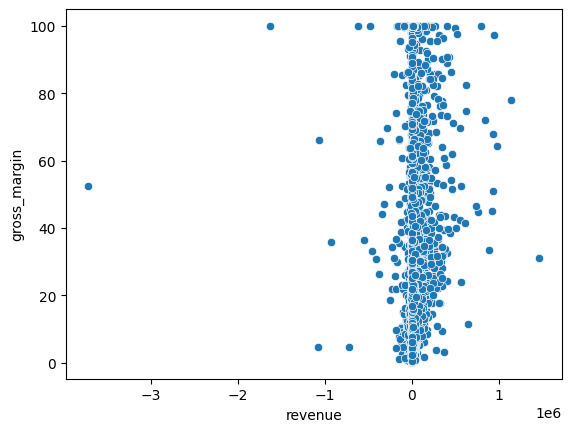

In [224]:
data_rev = data_rev[data_rev['gross_margin'] > 0.2]
data_rev = data_rev.reset_index()
sns.scatterplot(data=data_rev, x="revenue", y="gross_margin")
# График зависимости валовой рентабельности от выручки

<Axes: xlabel='revenue', ylabel='net_margin'>

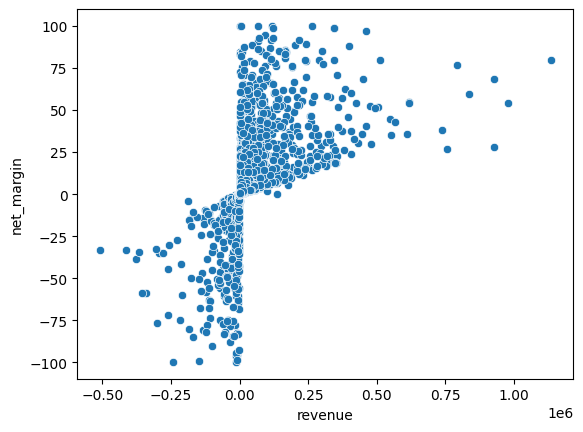

In [226]:
data_rev = data_rev[data_rev['net_margin'].between(-100, 100)]
data_rev = data_rev.reset_index()
sns.scatterplot(data=data_rev, x="revenue", y="net_margin")
# График зависимости чистой рентабельности от выручки

Оценка перспективностии отрасли
По снижению EBIT в 2023 и 2024г. относительно предыдущих лет можно предположить, что данная отрасль сейчас переживает свои не самые лучшие времена. Определенно свою роль сыграли санкции, введенные в 2022г., увеличение цен на стройматериалы и технику. Из-за увеличения ключевой ставки в 2023 и 2024г. снижается покупательская способность.


In [76]:
net_profit_df = list_df_copy[0][['inn','correction.financialResult.current2400']].merge(list_df_copy[1][['inn','correction.financialResult.current2400']], how='inner', on='inn')
net_profit_df['diff_n'] = round((net_profit_df['correction.financialResult.current2400_x']/(net_profit_df['correction.financialResult.current2400_y']+10**(-7)) - 1) * 100)
net_profit_df_1 = net_profit_df.dropna(subset=['diff_n'])

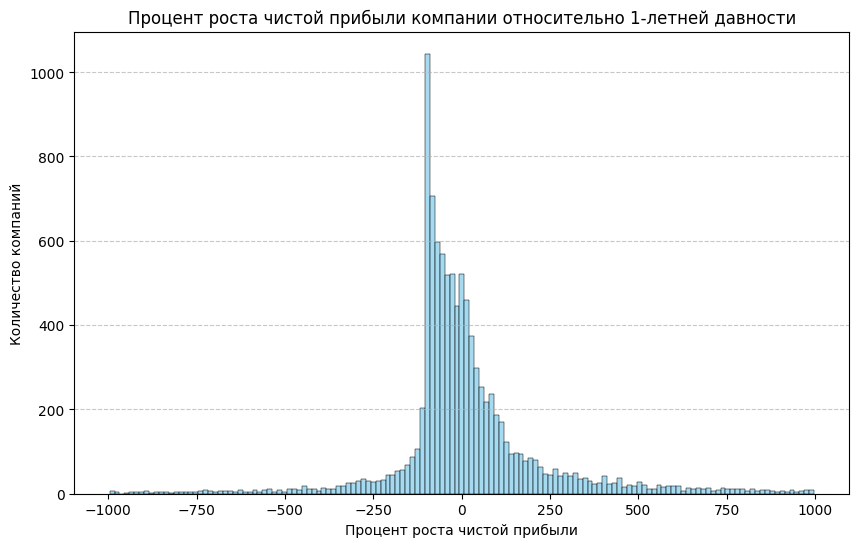

In [158]:
plt.figure(figsize=(10, 6))
data_p = net_profit_df_1[(net_profit_df_1.diff_n < 1000) & (net_profit_df_1.diff_n > -1000)]
sns.histplot(data_p.diff_n, kde=False, color="skyblue", edgecolor="black")
plt.title("Процент роста чистой прибыли компании относительно 1-летней давности")
plt.xlabel("Процент роста чистой прибыли")
plt.ylabel("Количество компаний")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [81]:
net_profit_df = list_df_copy[0][['inn','correction.financialResult.current2400']].merge(list_df_copy[2][['inn','correction.financialResult.current2400']], how='inner', on='inn')
net_profit_df['diff_n'] = round((net_profit_df['correction.financialResult.current2400_x']/(net_profit_df['correction.financialResult.current2400_y']+10**(-7)) - 1) * 100)
net_profit_df_2 = net_profit_df.dropna(subset=['diff_n'])

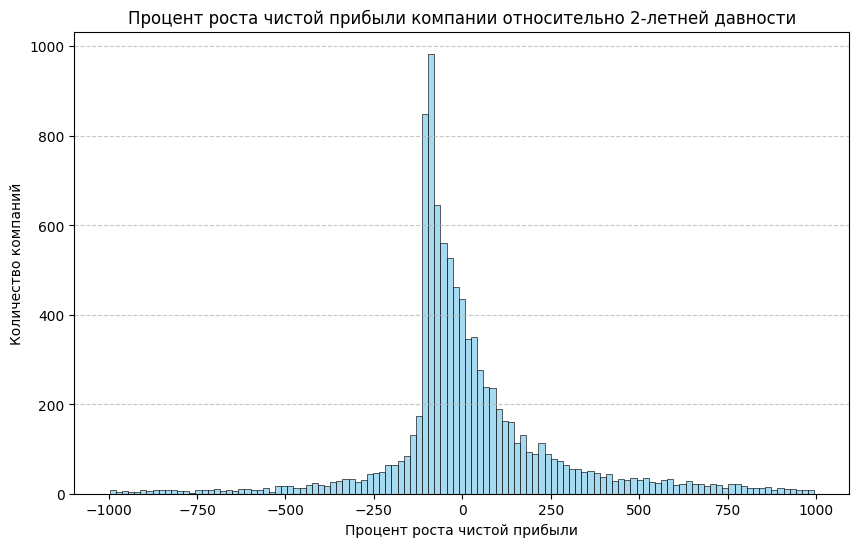

In [159]:
plt.figure(figsize=(10, 6))
data_p = net_profit_df_2[(net_profit_df_2.diff_n < 1000) & (net_profit_df_2.diff_n > -1000)]
sns.histplot(data_p.diff_n, kde=False, color="skyblue", edgecolor="black")
plt.title("Процент роста чистой прибыли компании относительно 2-летней давности")
plt.xlabel("Процент роста чистой прибыли")
plt.ylabel("Количество компаний")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [83]:
net_profit_df = list_df_copy[0][['inn','correction.financialResult.current2400']].merge(list_df_copy[3][['inn','correction.financialResult.current2400']], how='inner', on='inn')
net_profit_df['diff_n'] = round((net_profit_df['correction.financialResult.current2400_x']/(net_profit_df['correction.financialResult.current2400_y']+10**(-7)) - 1) * 100)
net_profit_df_3 = net_profit_df.dropna(subset=['diff_n'])

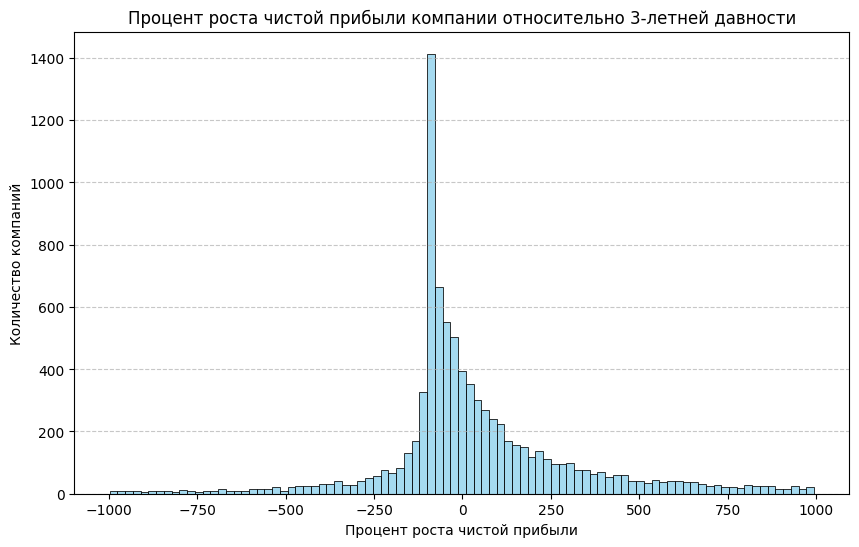

In [160]:
plt.figure(figsize=(10, 6))
data_p = net_profit_df_3[(net_profit_df_3.diff_n < 1000) & (net_profit_df_3.diff_n > -1000)]
sns.histplot(data_p.diff_n, kde=False, color="skyblue", edgecolor="black")
plt.title("Процент роста чистой прибыли компании относительно 3-летней давности")
plt.xlabel("Процент роста чистой прибыли")
plt.ylabel("Количество компаний")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()S

In [85]:
net_profit_df = list_df_copy[0][['inn','correction.financialResult.current2400']].merge(list_df_copy[4][['inn','correction.financialResult.current2400']], how='inner', on='inn')
net_profit_df['diff_n'] = round((net_profit_df['correction.financialResult.current2400_x']/(net_profit_df['correction.financialResult.current2400_y']+10**(-7)) - 1) * 100)
net_profit_df_4 = net_profit_df.dropna(subset=['diff_n'])

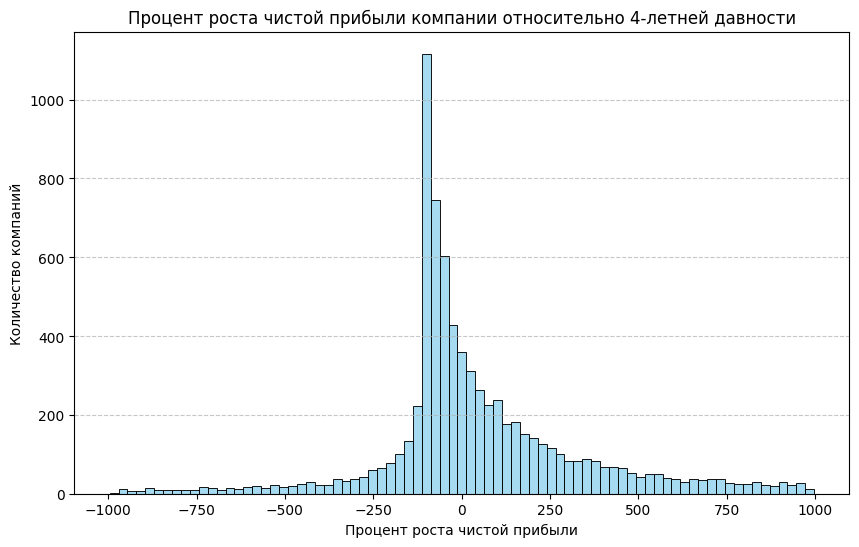

In [161]:
plt.figure(figsize=(10, 6))
data_p = net_profit_df_4[(net_profit_df_4.diff_n < 1000) & (net_profit_df_4.diff_n > -1000)]
sns.histplot(data_p.diff_n, kde=False, color="skyblue", edgecolor="black")
plt.title("Процент роста чистой прибыли компании относительно 4-летней давности")
plt.xlabel("Процент роста чистой прибыли")
plt.ylabel("Количество компаний")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Анализ графиков роста процента чистой прибыли компании относительно N-летней давности:
1. Все графики схожи между собой, не нормальны, имеют левостороннюю ассиметрию.
2. Количество компаний с отрицательным процентом роста чистой прибыли уменьшается с увеличением N, можно предположить, что многие компание с течением времени становятся все более устойчивыми и на длинном этапе получают положительную чистую прибыль. А новые компании, в силу своей "неопытности", еще не успевают выйти на положительную чистую прибыль.
3. Большинство компаний остаются в диапазоне от -150% до 150%
4. На всех графиках правый хвост толще, чем левый. Это значит, что намного больше тех компаний, которые имеют значительный прирост в чистой прибыли, нежели те компании, который имеют значительный упадок чистой прибыли.

In [ ]:
import plotly.express as px
import pandas as pd

us_cities = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/us-cities-top-1k.csv"
)

fig = px.scatter_map(
    us_cities,
    lat="lat",
    lon="lon",
    hover_name="City",
    hover_data=["State", "Population"],
    color_discrete_sequence=["fuchsia"],
    zoom=3,
    height=300,
)
fig.update_layout(map_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(map_bounds={"west": -180, "east": -50, "south": 20, "north": 90})
fig.show()
fig.write_html("test_plot.html")

In [112]:
data_top500 = list_df_copy[0].copy()
data_top500 = data_top500.sort_values(by=['correction.financialResult.current2110'], ascending=False).head(500)
print(data_top500.address.head(50))

0    197375, Санкт-Петербург г, ул 2-я Алексеевская...
0    400138, Волгоградская обл, г Волгоград, ул им....
0    143403, Московская обл, г Красногорск, ул Речн...
0    125373, Москва г, Походный пр-д, дом 4, корпус...
0    400005, Волгоградская обл, Волгоград г, Советс...
0    119017, Москва г, наб Кадашёвская, д 6/1/2 стр...
0    197198, Санкт-Петербург г, пр-кт Добролюбова, ...
0    428020, Чувашская Республика - Чувашия, Чебокс...
0    620014, Свердловская обл, г Екатеринбург, ул Ч...
0    144002, Московская обл, г. Электросталь, ул. К...
0    123112, Город Москва, вн.тер. г. Муниципальный...
0    142001, Московская обл, Домодедово г, Каширско...
0    г. Москва, муниципальный округ Академический в...
0    г. Москва, муниципальный округ Тверской вн.тер...
0    360024, Кабардино-Балкарская Респ,  Нальчик г,...
0    105118, Москва г, ш Энтузиастов, д 34, помещ 4А/4
0     115230, Москва г, проезд Электролитный, 1, 3, 1Б
0    620149, Свердловская обл, г Екатеринбург, ул Н...
0    19421

In [ ]:
import re

def find_6_digits(s):
    matches = re.findall(r'\d{6}', str(s))
    return int(matches[0]) if matches else None

data_top500['company_postal_code'] = data_top500['address'].apply(find_6_digits)

In [146]:
import numpy as np

cities_ru = pd.read_csv(
    "https://github.com/hflabs/city/blob/master/city.csv?raw=true"
)
cities_ru = cities_ru.dropna(subset=['postal_code'])

def find_nearest(array, value):
    diff = np.abs(array - value)
    idx = diff.argmin()
    return array[idx]

data_top500['nearest_postal_code'] = data_top500['company_postal_code'].apply(lambda x: find_nearest(cities_ru['postal_code'].values, x))
data_top500['lat'] = data_top500['nearest_postal_code'].apply(lambda x: cities_ru.loc[cities_ru['postal_code'] == x, 'geo_lat'].values[0])
data_top500['lng'] = data_top500['nearest_postal_code'].apply(lambda x: cities_ru.loc[cities_ru['postal_code'] == x, 'geo_lon'].values[0])


In [147]:
print(data_top500.head(10))

                                            fullName         inn  \
0  Общество с ограниченной ответственностью "АВАН...  7804403002   
0  ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "СПЕЦ...  7325124442   
0  ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "СТРО...  7733757980   
0  Общество с ограниченной ответственностью "СГМ ...  7719645547   
0  Общество с ограниченной ответственностью "А" С...  3444259931   
0  Общество с ограниченной ответственностью "Спец...  7703430017   
0  Общество с ограниченной ответственностью "РСТИ...  7813617113   
0  Открытое акционерное общество Инвестиционно-ст...  2126003691   
0                                      ООО "ИНЖЕНЕР"  6661069066   
0  Общество с ограниченной ответственностью "СТРО...  5053056969   

                                             address  \
0  197375, Санкт-Петербург г, ул 2-я Алексеевская...   
0  400138, Волгоградская обл, г Волгоград, ул им....   
0  143403, Московская обл, г Красногорск, ул Речн...   
0  125373, Москва г, Походн

In [156]:
data_top500_fig = data_top500[['fullName', 'address', 'inn', 'correction.financialResult.current2400', 'lat', 'lng']]
data_top500_fig = data_top500_fig.rename(columns={'correction.financialResult.current2400': 'revenue'})

fig = px.scatter_map(
    data_top500_fig,
    lat="lat",
    lon="lng",
    hover_name="fullName",
    hover_data=["address", "inn", 'revenue'],
    color_discrete_sequence=["fuchsia"],
    zoom=3,
    height=300,
)
fig.update_layout(map_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(map_bounds={"west": 20, "east": 170, "south": 20, "north": 90})
fig.show()
fig.write_html("test_plot_ru.html")